In [11]:
%load_ext autoreload
%autoreload 2

from lablr import *
from energy import *
from fast_energy import *
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Local Iterations: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


Lowest energy: 3.125697438919019


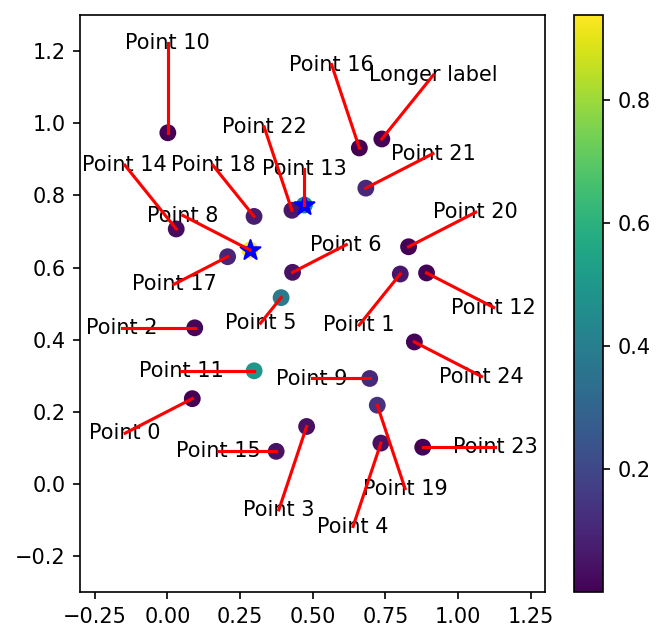

In [29]:
rand_gen = np.random.default_rng(3)
points = rand_gen.uniform(0, 1, (25, 2))
labels = [f"Point {i}" for i in range(len(points))]
labels[7] = "Longer label"

allowed_radii = [0.05, 0.1, 0.2, 0.25]
allowed_angles = np.linspace(0, 360, 16, endpoint=False)

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

best_label_pos, best_label_energies, lowest_energy = optimize_label_positions_fast(
    ax,
    points,
    labels,
    allowed_radii=allowed_radii,
    allowed_angles=allowed_angles,
    n_random_iterations=1000,
    n_local_iterations=10,
)
cbar = ax.scatter(points[:, 0], points[:, 1], s=50, c=best_label_energies, zorder=1)
cbar = plt.colorbar(cbar, ax=ax)

print("Lowest energy:", lowest_energy)

crossing_energies = calc_crossing_energies_old(points, best_label_pos)
overlap_energies = calc_overlap_energies_old(points, best_label_pos, labels, ax=ax)

crossing = points[crossing_energies > 0]
overlap = points[overlap_energies > 0]

ax.scatter(crossing[:, 0], crossing[:, 1], s=100, c="red", marker='x', zorder=2)
ax.scatter(overlap[:, 0], overlap[:, 1], s=100, c="blue", marker='*', zorder=2)

for i, label in enumerate(labels):
    label_pos = best_label_pos[i]
    ax.text(
        label_pos[0],
        label_pos[1],
        label,
        fontsize=10,
        ha="center",
        va="center",
        zorder=3,
    )

for i, point in enumerate(points):
    plt.plot([point[0], best_label_pos[i, 0]], [point[1], best_label_pos[i, 1]], c='r', zorder=5)

plt.xlim(-0.3, 1.3)
plt.ylim(-0.3, 1.3)
plt.show()

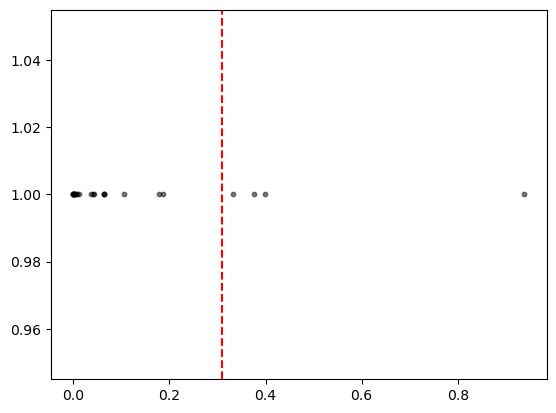

In [26]:
# print(np.std(best_label_energies)*2)
plt.axvline(np.std(best_label_energies)*1.5, color='r', linestyle='--')
plt.scatter(best_label_energies, np.ones_like(best_label_energies), s=10, c='k', zorder=4, alpha=0.5)
plt.show()

Explicit Testing Visualization

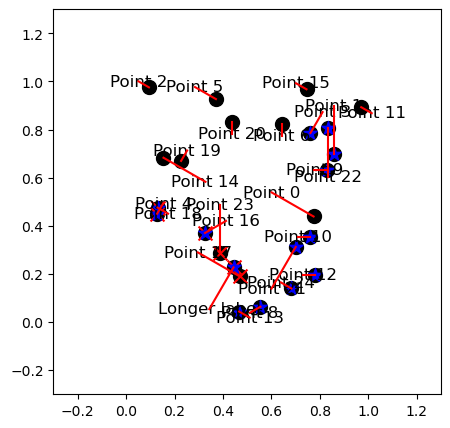

In [13]:
rand_gen = np.random.default_rng(42)
points = rand_gen.uniform(0, 1, (25, 2))
labels = [f"Point {i}" for i in range(len(points))]
labels[7] = "Longer label"

allowed_radii = [0.05, 0.1, 0.2]
allowed_angles = np.linspace(0, 360, 12, endpoint=False)

fig, ax = plt.subplots(figsize=(5, 5))

label_pos = gen_random_label_pos(points, allowed_radii, allowed_angles)

point_energies = calc_label_point_energies(
    points, label_pos, influence_extent=np.mean(allowed_radii)
)
label_energies = calc_label_label_energies(
    label_pos, influence_extent=np.mean(allowed_radii)
)
crossing_energies = calc_crossing_energies(points, label_pos)
overlap_energies = calc_overlap_energies(points, label_pos, labels, ax=ax)

energies = (
    point_energies + label_energies + crossing_energies + overlap_energies
)
total_energy = np.sum(energies)

crossing = points[crossing_energies > 0]
overlap = points[overlap_energies > 0]


plt.scatter(points[:, 0], points[:, 1], s=100, c="black", zorder=2)
plt.scatter(crossing[:, 0], crossing[:, 1], s=100, c="red", marker='x', zorder=2)
plt.scatter(overlap[:, 0], overlap[:, 1], s=100, c="blue", marker='*', zorder=2)

for i, label in enumerate(labels):
    pos = label_pos[i]
    ax.text(
        pos[0],
        pos[1],
        label,
        fontsize=12,
        ha="center",
        va="center",
        zorder=3,
    )

for i, point in enumerate(points):
    plt.plot([point[0], label_pos[i, 0]], [point[1], label_pos[i, 1]], c='r', zorder=5)

plt.xlim(-0.3, 1.3)
plt.ylim(-0.3, 1.3)
plt.show()

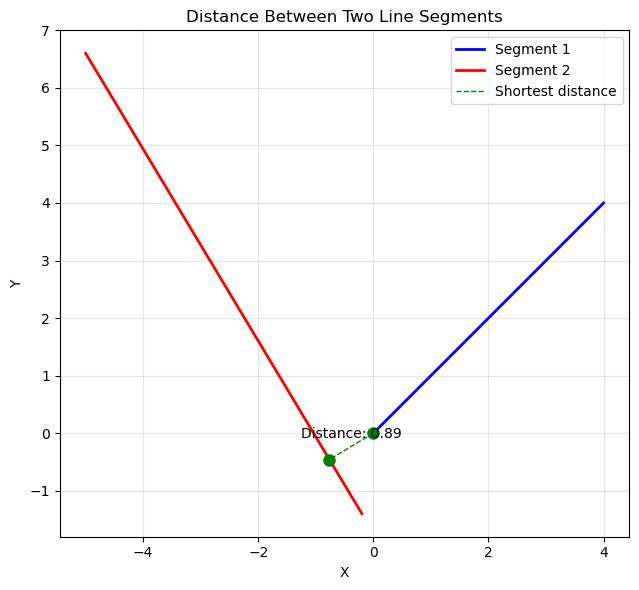

In [14]:
# Find the closest points (for visualization)
# This part isn't optimized but it's just for visualization
def get_closest_points(seg1, seg2):
    x0, y0, x1, y1 = seg1
    x2, y2, x3, y3 = seg2
    
    u = np.array([x1 - x0, y1 - y0])
    v = np.array([x3 - x2, y3 - y2])
    w = np.array([x0 - x2, y0 - y2])
    
    a = np.dot(u, u)
    b = np.dot(u, v)
    c = np.dot(v, v)
    d = np.dot(u, w)
    e = np.dot(v, w)
    
    D = a * c - b * b
    sc, sN, sD = D, D, D
    tc, tN, tD = D, D, D
    
    if D < 1e-8:
        sN = 0.0
        sD = 1.0
        tN = e
        tD = c
    else:
        sN = (b * e - c * d)
        tN = (a * e - b * d)
        if sN < 0.0:
            sN = 0.0
            tN = e
            tD = c
        elif sN > sD:
            sN = sD
            tN = e + b
            tD = c
    
    if tN < 0.0:
        tN = 0.0
        if -d < 0.0:
            sN = 0.0
        elif -d > a:
            sN = sD
        else:
            sN = -d
            sD = a
    elif tN > tD:
        tN = tD
        if (-d + b) < 0.0:
            sN = 0
        elif (-d + b) > a:
            sN = sD
        else:
            sN = (-d + b)
            sD = a
    
    sc = 0.0 if abs(sN) < 1e-8 else sN / sD
    tc = 0.0 if abs(tN) < 1e-8 else tN / tD
    
    p1 = np.array([x0, y0]) + sc * u
    p2 = np.array([x2, y2]) + tc * v
    
    return p1, p2


# Create a simple example with two line segments
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Define two line segments
seg1 = (0, 0, 4, 4)
seg2 = (-0.2, -1.4, -5, 6.6)

# Plot the segments
ax.plot([seg1[0], seg1[2]], [seg1[1], seg1[3]], 'b-', linewidth=2, label='Segment 1')
ax.plot([seg2[0], seg2[2]], [seg2[1], seg2[3]], 'r-', linewidth=2, label='Segment 2')

# Calculate the distance using our function
distance = distance_between_segments_fast(
    seg1[0], seg1[1], seg1[2], seg1[3],
    seg2[0], seg2[1], seg2[2], seg2[3]
)

p1, p2 = get_closest_points(seg1, seg2)

# Plot the closest points and the connecting line
ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'g--', linewidth=1, label='Shortest distance')
ax.plot(p1[0], p1[1], 'go', markersize=8)
ax.plot(p2[0], p2[1], 'go', markersize=8)

ax.text((p1[0] + p2[0])/2, (p1[1] + p2[1])/2 + 0.1, 
        f'Distance: {distance:.2f}', ha='center', va='bottom')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Distance Between Two Line Segments')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()
